In [1]:
%reset -f
import sys
import numpy as np
sys.path.insert(0, '..')
from wavhandler import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from utils_train import *
import deepdish as dd
import os
import glob
from natsort import natsorted
import matplotlib.pyplot as plt

!cd /home/kalfasyan/projects/wingbeat_frequencies/temp_data/from_cluster/

In [2]:
os.chdir('/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/')
!pwd

/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results


In [3]:
def extract_dl_results(d, custom=False):
    idx_bst = d['val_loss'].index(min(d['val_loss']))
    train_score = d['train_score'][idx_bst]
    val_score = d['val_score'][idx_bst]
#     train_loss = d['train_loss'][idx_bst]
#     val_loss = d['val_loss'][idx_bst]
    balanced_acc_test = d['balanced_acc_test']
    logloss_test = d['logloss_test']
    if custom:
        return train_score,val_score,balanced_acc_test,logloss_test
    else:
        return f'{train_score:.2f}/{val_score:.2f}/{balanced_acc_test:.2f}, {logloss_test:.2f}'

def extract_ml_results(d, custom=False):
    train_score = d['train_score']
    val_score = d['val_score']
    balanced_acc_test = d['balanced_acc_test']
    logloss_test = d['logloss_test']
    if custom:
        return train_score,val_score,balanced_acc_test,logloss_test
    else:
        return f'{train_score:.2f}/{val_score:.2f}/{balanced_acc_test:.2f}, {logloss_test:.2f}'

fnames_dl = natsorted(glob.glob('/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/dl/**results.h5'))
#fnames_dl
fnames_ml = natsorted(glob.glob('/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/**results.h5'))

# RESULTS TABLE

In [4]:
for f in fnames_ml:
    d = dd.io.load(f)['results']
    f = f.split('/')[-1][:-4]
    lk = list(d.keys())

    if len(lk) == 1:
        if lk[0] == 'random':
            print(f"{f}:\t\t {extract_ml_results(d['random'])}")
        elif lk[0] == 'randomcv':
            print(f"{f}:\t\t {extract_ml_results(d['randomcv'])}")
    elif len(lk) == 5:
        tmp = []
        for i in range(5):
            tmp.append(extract_ml_results(d[f'custom_{i}'], custom=True))
        stacked = np.vstack(tmp)
        stacked = np.mean(stacked, axis=0)
        print(f'{f}:\t\t {stacked[0]:.2f}/{stacked[1]:.2f}/{stacked[2]:.2f}, {stacked[3]:.2f}')

random_psd_dB_knn_result:		 0.78/0.73/0.73, 2.02
random_psd_dB_randomforest_result:		 0.97/0.77/0.76, 0.71
random_psd_dB_xgboost_result:		 0.98/0.83/0.82, 0.50
randomcv_psd_dB_knn_result:		 0.78/0.75/0.50, 8.39
randomcv_psd_dB_randomforest_result:		 0.97/0.78/0.49, 1.47
randomcv_psd_dB_xgboost_result:		 0.98/0.83/0.54, 1.92


In [5]:
for f in fnames_dl:
    d = dd.io.load(f)['results']
    f = f.split('/')[-1][:-4]
    lk = list(d.keys())

    if len(lk) == 1:
        if lk[0] == 'random':
            print(f"{f}:\t\t {extract_dl_results(d['random'])}")
        elif lk[0] == 'randomcv':
            print(f"{f}:\t\t {extract_dl_results(d['randomcv'])}")
    elif len(lk) == 5:
        tmp = []
        for i in range(5):
            tmp.append(extract_dl_results(d[f'custom_{i}'], custom=True))
        stacked = np.vstack(tmp)
        stacked = np.mean(stacked, axis=0)
        print(f'{f}:\t\t {stacked[0]:.2f}/{stacked[1]:.2f}/{stacked[2]:.2f}, {stacked[3]:.2f}')


/home/kalfasyan/miniconda3/envs/wbtf2/lib/python3.6/site-packages/deepdish/io/hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


custom_psd_dB_conv1d_result:		 0.88/0.81/0.54, 1.97
custom_psd_dB_gru_result:		 0.89/0.81/0.54, 2.00
custom_raw_conv1d_result:		 0.96/0.90/0.68, 1.42
custom_raw_gru_result:		 0.95/0.89/0.68, 1.31
custom_stft_DenseNet121_result:		 0.97/0.90/0.64, 2.16
random_psd_dB_conv1d_result:		 0.87/0.83/0.84, 0.46
random_psd_dB_gru_result:		 0.89/0.84/0.84, 0.48
random_raw_conv1d_result:		 0.93/0.91/0.90, 0.27
random_raw_gru_result:		 0.95/0.90/0.90, 0.29
random_stft_DenseNet121_result:		 0.97/0.92/0.92, 0.24
randomcv_psd_dB_conv1d_result:		 0.88/0.84/0.54, 1.89
randomcv_psd_dB_gru_result:		 0.90/0.84/0.54, 2.13
randomcv_raw_conv1d_result:		 0.93/0.91/0.68, 1.24
randomcv_raw_gru_result:		 0.94/0.91/0.67, 1.31
randomcv_stft_DenseNet121_result:		 0.95/0.92/0.63, 1.61


# CONFUSION MATRIX

In [47]:
path_results = '/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/'
path_dl = f'{path_results}dl/'
path_ml = f'{path_results}ml/'

def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

In [34]:
data = Dataset('Wingbeats')
X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=data, return_label_encoder=True)

Species: Ae. aegypti.
Read 85553 filenames in 2.41 seconds.
['20170209', '20170208', '20170210', '20170206', '20170213', '20170211', '20170207', '20161213', '20170212', '20161212']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 2.30 seconds.
['20170301', '20170228', '20170227', '20170103', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 2.41 seconds.
['20170313', '20170202', '20170315', '20170314', '20170318', '20170204', '20170201', '20170131', '20170203', '20170317', '20170320', '20170319', '20170316', '20170205', '20170206', '20170130']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 2.37 seconds.
['20170110', '20170109', '20170116', '20170119', '20170120', '20170117', '20170121', '20170118', '20170122', '20170123']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Read 74599 filenames in 2.28 seconds.
['20161220', '2016

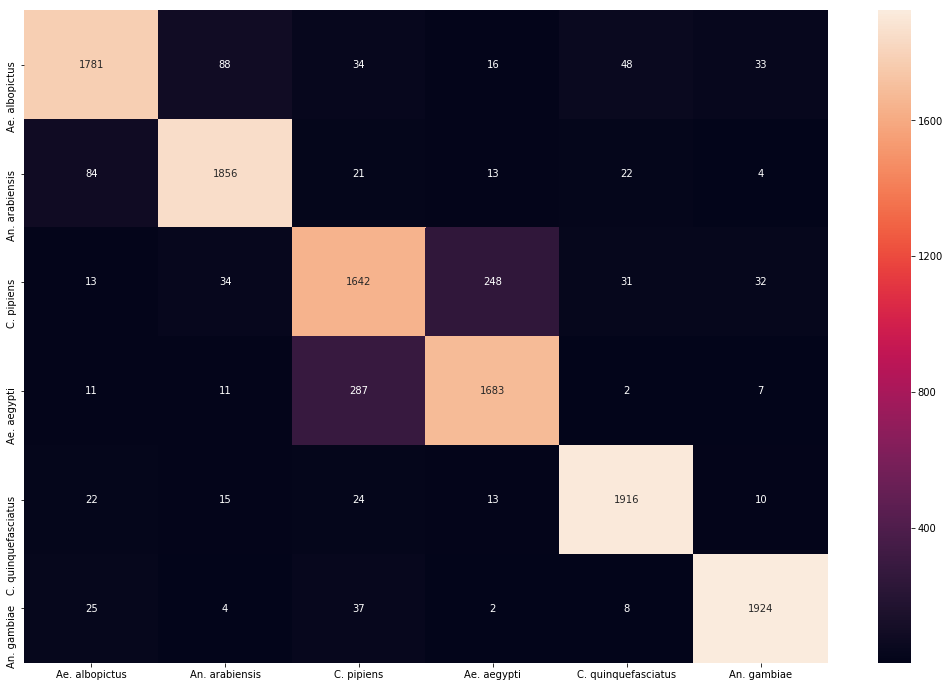

In [54]:
splitting = 'random'
cus = 0
data_setting = 'raw'
model_setting = 'conv1d'
if splitting == 'custom':
    d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][f'custom_{cus}']
elif splitting == 'random' or splitting == 'randomcv':
    d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][splitting]

y_pred = np.argmax(d['y_pred'], axis=1)
y_test = d['y_test']
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
integerMapping = get_integer_mapping(le)
mapping = {v: k for k, v in integerMapping.items()}
y = [mapping[x] for x in y_test]

plt.figure(figsize=(18,12))
labels = pd.Series(y).unique().tolist()
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='.0f')

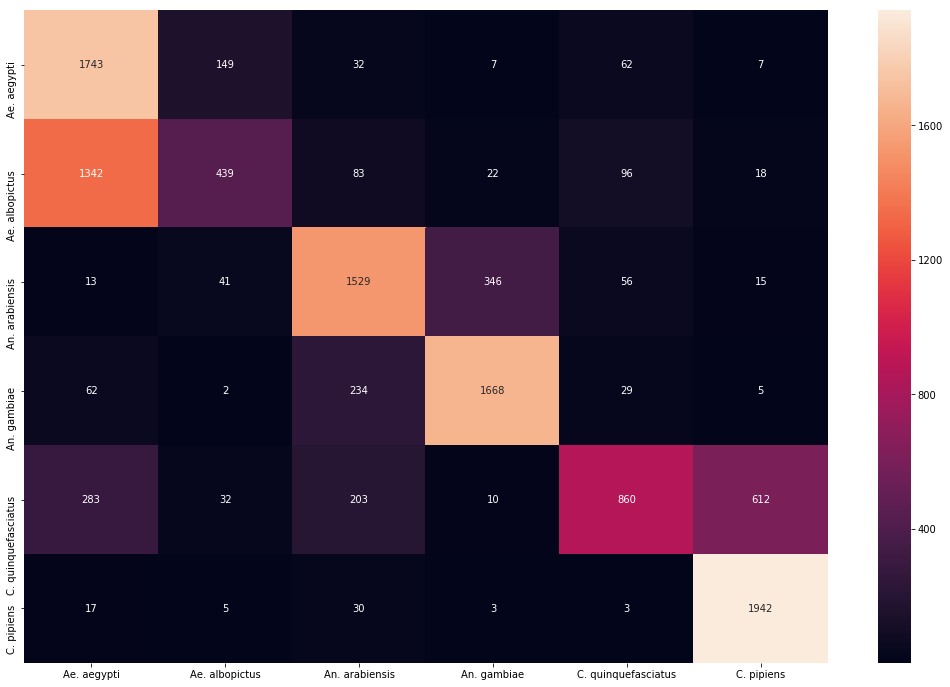

In [52]:
splitting = 'randomcv'
cus = 0
data_setting = 'raw'
model_setting = 'conv1d'
if splitting == 'custom':
    d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][f'custom_{cus}']
elif splitting == 'random' or splitting == 'randomcv':
    d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][splitting]

y_pred = np.argmax(d['y_pred'], axis=1)
y_test = d['y_test']
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
integerMapping = get_integer_mapping(le)
mapping = {v: k for k, v in integerMapping.items()}
y = [mapping[x] for x in y_test]

plt.figure(figsize=(18,12))
labels = pd.Series(y).unique().tolist()
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='.0f')

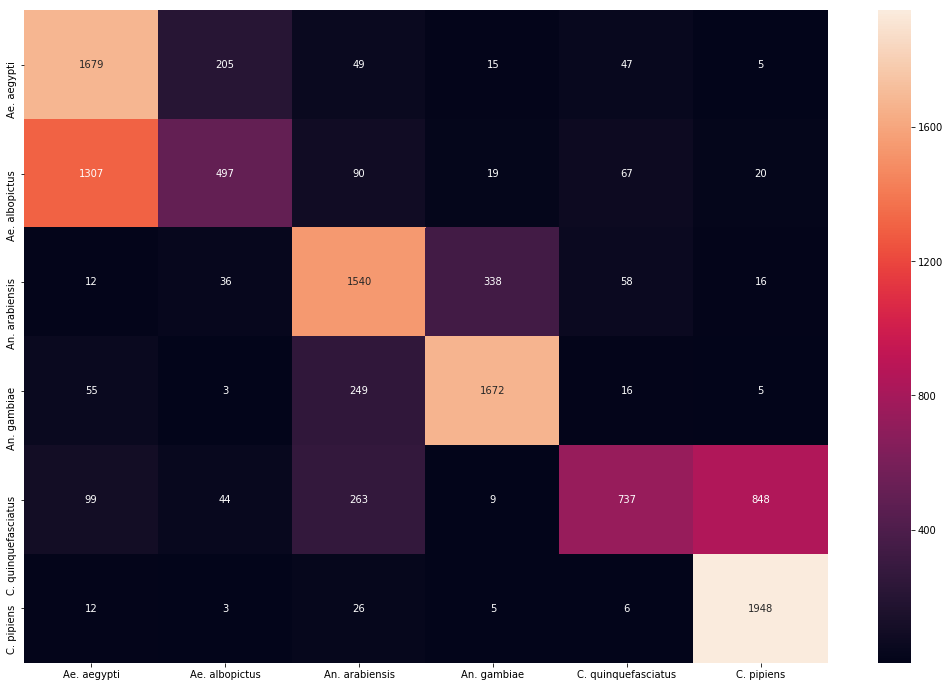

In [56]:
splitting = 'custom'
cus = 4
data_setting = 'raw'
model_setting = 'conv1d'
if splitting == 'custom':
    d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][f'custom_{cus}']
elif splitting == 'random' or splitting == 'randomcv':
    d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][splitting]

y_pred = np.argmax(d['y_pred'], axis=1)
y_test = d['y_test']
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
integerMapping = get_integer_mapping(le)
mapping = {v: k for k, v in integerMapping.items()}
y = [mapping[x] for x in y_test]

plt.figure(figsize=(18,12))
labels = pd.Series(y).unique().tolist()
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='.0f')